In [10]:
import os
import gc #limpar memória
import sys
import yaml
import time
import glob
import h5py
#import faiss # environment tfpy, porque é onde está o faiss. Faiss não é compatível com tensorflow e python versions, tem de estar organizado assim
import click
import curses
import librosa
import wave

import numpy as np # tem de ser 1.23.5, por causa do deepdish
#import pandas as pd
import deepdish as dd
import tensorflow as tf


from model_RA.fp_RA.melspec.melspectrogram_RA import get_melspec_layer
from model_RA.fp_RA.nnfp import get_fingerprinter
from model_RA.utils.dataloader_keras import genUnbalSequence

In [11]:
tf.__version__

'2.15.0'

In [12]:
np.__version__ # tem de ser 1.23.5

'1.23.5'

In [13]:
tf.config.list_physical_devices('GPU')

[]

In [14]:
# Listar dispositivos físicos disponíveis
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    print("GPUs disponíveis:")
    for gpu in physical_devices:
        print(gpu)
    
    # Ver propriedades detalhadas das GPUs
    for gpu in physical_devices:
        details = tf.config.experimental.get_device_details(gpu)
        print(gpu, details)
else:
    print("Nenhuma GPU disponível.")

Nenhuma GPU disponível.


# Pipeline

## 1. Construção do BD Vetorial

1) Carregar os vetores embedded
2) Criar a instância do Faiss
3) Carregar o Faiss com os Dados

## 2. Leitura do Modelo Neural

1) Carrega a classe do modelo
2) ler o modelo

## 3. Predição

1) Receber o dado (áudio query)
2) calcular o embedded - model.predict
3) buscar o índice no BD vetorial
4) recuperar os metadados associados ao índice (nome da música, etc)
5) apresentar ao cliente

# Construção Demo

## 1. Construção do BD Vetorial

### Carrega os embeddings de cada música da base de dados

## 2. Leitura do modelo Neural

In [15]:
def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg

In [16]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_fp


@tf.function
def predict(X, m_pre, m_fp):
    """ 
    Test step used for mini-search-validation 
    X -> (B,1,8000)
    """
    #tf.print(X)
    feat = m_pre(X)  # (nA+nP, F, T, 1)
    m_fp.trainable = False
    emb_f = m_fp.front_conv(feat)  # (BSZ, Dim)
    emb_gf = m_fp.div_enc(emb_f)
    emb_gf = tf.math.l2_normalize(emb_gf, axis=1)
    return emb_gf # L2(g(f(.))

In [17]:
#input_dir = '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-dummy-db-100k-full/fma_full/'
#root_out = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dummyEmb/'
#input_dir = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/' # debug
input_dir = '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db'
root_out = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dbEmb'

win_size_sec = 1
hop_size_sec = 0.5

config = "default_RA"
cfg = load_config(config)

m_pre, m_fp = build_fp(cfg)

#to device
#tratar como rede de execução

checkpoint_root_dir:str = "./logs/CHECK_BFTRI_100/101/"
checkpoint = tf.train.Checkpoint(m_fp)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_root_dir))

cli: Configuration from ./config/default_RA.yaml


## 3. Predição
### Número de indices de retorno do 'faiss search' e metadados

### Carrega áudio-query e cria o embedding do mesmo

In [18]:
def get_audio(audiofile, sr_target=8000):
    audio, fs = librosa.load(audiofile, mono=True, sr=sr_target)
    return audio, fs

def nframe(audio, win_size, hop_size):
    frames =librosa.util.frame(x=audio, frame_length=win_size, hop_length=hop_size)
    return frames

In [19]:
files = glob.glob(os.path.join(input_dir, '**/*.wav') ,recursive = True)
files = sorted(files)

In [21]:
def process_in_blocks(tensor, block_size):
    """Função para dividir um tensor grande em blocos menores."""
    #print(f"{type(tensor)}-{tensor.shape}-{tensor}")
    #print(f"{tensor.shape[0]}-{tensor.shape[1]}-{tensor.shape[2]}")
    total_size = tensor.shape[0] #2914
    num_blocks = tensor.shape[0] // block_size
    remainder = total_size % block_size
    remainder_range = num_blocks * block_size

    print(num_blocks, remainder, total_size)
    for i in range(num_blocks):

        #last block
        if (i+1)*block_size >= remainder_range:
            yield tensor[i*remainder:(i+1)*remainder,:,:]

        #todos os primeiros blocks menos o último, caso sobre
        yield tensor[i*block_size:(i+1)*block_size,:,:]

#Atenção, música 000422.wav tem 24 minutos e não consigo criar embedding dela.
#001 .wav também tem muitos MB, parece com 20MB .wav vai ser complicado.

In [22]:
enq = tf.keras.utils.OrderedEnqueuer(files, use_multiprocessing=True, shuffle=False)
enq.start(workers=cfg['DEVICE']['CPU_N_WORKERS'], max_queue_size=cfg['DEVICE']['CPU_MAX_QUEUE'])
try:
    iteration_count = 0  # Contador para limpeza de memória periódica
    memory_cleaning_interval = 10  # Intervalo para limpeza de memória
    i = 0
    while i < len(enq.sequence):
        if iteration_count % memory_cleaning_interval == 0:
            tf.keras.backend.clear_session()  # Limpar memória da GPU
            gc.collect()  # Limpar memória da CPU

        X = next(enq.get()) # X: Tuple(Xa, Xp)
        print(f"{i}-{X}")
        audio, fs = get_audio(audiofile=X)
        audio_frames = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
        #print(f"audio_frames_1:{audio_frames.shape}-{type(audio_frames)}")
        audio_frames = np.transpose(audio_frames[np.newaxis, ...], (2, 0,1))

        print(audio_frames.shape)
        # b) gerar o embedded
        with tf.device("/GPU:0"):
            block_size = 1024
            emb_blocks = []
            if len(audio_frames) > block_size:
                for block in process_in_blocks(audio_frames, block_size):
                    #emb = predict(audio_frames, m_pre, m_fp) # TensorShape([473, 128])
                    #print(block)
                    emb_blocks.append(predict(block, m_pre, m_fp)) # TensorShape([473, 128])
                
                emb_blocks = np.concatenate(emb_blocks, axis=0)
                emb = emb_blocks
            
            else:
                emb = predict(audio_frames, m_pre, m_fp) # TensorShape([473, 128])
                emb = emb.numpy() # (473, 128)
                
        
        print(f"{emb.shape}")
        

        #Cria .h5 files
        parts = X.split("/")
        dir_name = parts[-2]
        file_name = parts[-1].split(".")[0]
        output_dir = os.path.join(root_out, dir_name)
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        file_out =  os.path.join(output_dir, file_name + '.h5')
        dd.io.save(file_out, emb)

        i += 1
        iteration_count+= 1
    #enq.stop()

except Exception as e:
    print(f"Erro encontrado: {e}")
finally:
    enq.stop()

0-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/000/000134.wav
(59, 1, 8000)
(59, 128)
1-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/000/000512.wav
(59, 1, 8000)
(59, 128)
2-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/000/000760.wav
(59, 1, 8000)
(59, 128)
3-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/000/000768.wav
(59, 1, 8000)
(59, 128)
4-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/000/000776.wav
(59, 1, 8000)
(59, 128)
5-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/001/001018.wav
(59, 1, 8000)
(59, 128)
6-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/001/001028.wav
(59, 1, 8000)
(59, 128)
7-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-50

Exception in thread Thread-4 (_run):
Traceback (most recent call last):
  File "/home/rodrigo/anaconda3/envs/tf15/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/rodrigo/anaconda3/envs/tf15/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/rodrigo/anaconda3/envs/tf15/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rodrigo/anaconda3/envs/tf15/lib/python3.11/site-packages/keras/src/utils/data_utils.py", line 847, in _run
    self.sequence.on_epoch_end()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'list' object has no attribute 'on_epoch_end'


(59, 128)
499-/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-query-db-500-30s/db/149/149719.wav
(59, 1, 8000)
(59, 128)


In [ ]:
#Dividir em batches para poder usar a gpu sem exceder a memória

#a) carregar áudio
emb_list = []
music_names = []
#files = files[181:]

batch_size = 10
for k in range(0, len(files), batch_size):
    print(k)
    tf.keras.backend.clear_session()#limpar memória da GPU
    gc.collect()#limpar memória da CPU

    batch_files = files[k:k+batch_size]
    #print(batch_files[0], len(batch_files))

    for i, file in enumerate(batch_files):
        emb = 0
        #print(f"{i}-{len(files)}-{file}")
        audio, fs = get_audio(audiofile=file)
        audio_frames = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
        audio_frames = np.transpose(audio_frames[np.newaxis, ...], (2, 0,1))
        #print(audio_frames.shape)

        # b) gerar o embedded
        with tf.device("/GPU:0"):
            emb = predict(audio_frames, m_pre, m_fp) # TensorShape([473, 128])
        
        emb = emb.numpy() # (473, 128)
        #emb_list.append(emb)

        #Cria .h5 files
        parts = file.split("/")
        dir_name = parts[-2]
        file_name = parts[-1].split(".")[0]
        output_dir = os.path.join(root_out, dir_name)
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        file_out =  os.path.join(output_dir, file_name + '.h5')
        
        dd.io.save(file_out, emb)

    tf.keras.backend.clear_session()#limpar memória da GPU
    gc.collect()#limpar memória da CPU

    """
    for i, file in enumerate(files):
        print(f"{i}-{len(files)}-{file}")
        audio, fs = get_audio(audiofile=file)
        audio_frames = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
        audio_frames = np.transpose(audio_frames[np.newaxis, ...], (2, 0,1))
        
        

        parts = file.split("/")
        dir_name = parts[-2]
        file_name = parts[-1].split(".")[0]
        output_dir = os.path.join(root_out, dir_name)
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        file_out =  os.path.join(output_dir, file_name + '.h5')
        
        dd.io.save(file_out, emb)
    """

In [ ]:
#Dividir em batches para poder usar a gpu sem exceder a memória

#a) carregar áudio
emb_list = []
music_names = []

for i, file in enumerate(files):
    print(f"{i}-{len(files)}-{file}")
    audio, fs = get_audio(audiofile=file)
    audio_frames = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
    audio_frames = np.transpose(audio_frames[np.newaxis, ...], (2, 0,1))
    
    # b) gerar o embedded
    with tf.device('/gpu:0'):
        emb = predict(audio_frames, m_pre, m_fp) # TensorShape([473, 128])
    
    emb = emb.numpy() # (473, 128)

    parts = file.split("/")
    dir_name = parts[-2]
    file_name = parts[-1].split(".")[0]
    output_dir = os.path.join(root_out, dir_name)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    file_out =  os.path.join(output_dir, file_name + '.h5')
    
    dd.io.save(file_out, emb)

Faiss - parte

ler .h5

In [86]:
h5_dummy_teste = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/'

h5files = glob.glob(os.path.join(h5_dummy_teste + '**/*.h5') ,recursive = True)
h5files = sorted(h5files)

In [85]:
h5files

['/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000003.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000020.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000026.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000030.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000046.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000048.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000135.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000136.h5',
 '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/debug_audios/000137.h5']

In [99]:
embeddings_dummy = []
music_names = []
for i, h5file in enumerate(h5files):
    embeddings_dummy.append(dd.io.load(h5file))
    base_name = os.path.splitext(os.path.basename(h5file))[0]
    music_names.extend([base_name] * len(embeddings_dummy[i]))

In [88]:
embeddings_dummy = np.concatenate(embeddings_dummy, axis = 0)

faiss

In [42]:
def create_index(db_embeddings, nogpu=True, n_centroids=256, code_sz=64, nbits=8):
    #faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits), com d=, nlist=n_centroids=50, m=code_sz=8, bits=nbits=8
    #faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)
    #n_centroids -> clusters
    
    d = db_embeddings.shape[1]  # Dim emb #len(db_embeddings[0][0][0])

    quantizer = faiss.IndexFlatL2(d)

    code_sz = 64 # power of 2
    n_centroids = 256 #Veronoi Cells
    nbits = 8  # nbits must be 8, 12 or 16, The dimension d should be a multiple of M.
    index = faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits) #Adicona clustering

    # Se não usar GPU
    if not nogpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    if not index.is_trained:
        index.train(db_embeddings)

    # Adicionando os embeddings ao índice
    index.add(db_embeddings)
    print(f"Foram adicionados:{index.ntotal}")
    
    return index

In [43]:
faiss_engine = create_index(embeddings_dummy, nogpu=True, n_centroids=256, code_sz=64, nbits=8)

WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7571 points to 256 centroids: please prov

Foram adicionados:7571


query

In [48]:
audio_dir = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/debug_audios/000003.wav'
win_size_sec = 1
hop_size_sec = 0.5

In [59]:
#a) carregar áudio
emb_list_query = []
music_names_query = []

audio_query, fs_query = get_audio(audiofile=audio_dir)
audio_frames_query = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
audio_frames_query = np.transpose(audio_frames_query[np.newaxis, ...], (2, 0,1))

# b) gerar o embedded
emb_query = predict(audio_frames_query, m_pre, m_fp) # TensorShape([473, 128])
emb_query = emb_query.numpy() # (473, 128)

base_name_query = os.path.splitext(os.path.basename(audio_dir))[0]
music_names_query.extend([base_name_query] * len(emb_query))
emb_list_query.append(emb_query)

2024-06-22 14:45:37.974837: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5165285376 exceeds 10% of free system memory.


In [60]:
emb_list_array_query = np.concatenate(emb_list_query, axis = 0)

In [63]:
topN = 1
D, I = faiss_engine.search(embeddings_dummy, topN) # D: Distâncias, I: Índices dos resultados

In [66]:
D3, I3 = faiss_engine.search(emb_list_array_query, topN) # D: Distâncias, I: Índices dos resultados

In [124]:
music_names = np.array(music_names)

map_obra = lambda idx: music_names[idx]

obras_result = map_obra(I)

In [125]:
obras_result

array([['000003'],
       ['000003'],
       ['000003'],
       ...,
       ['000137'],
       ['000137'],
       ['000137']], dtype='<U6')

In [122]:
obras_result[0] 

array(['000003'], dtype='<U6')

plot - musicas todas

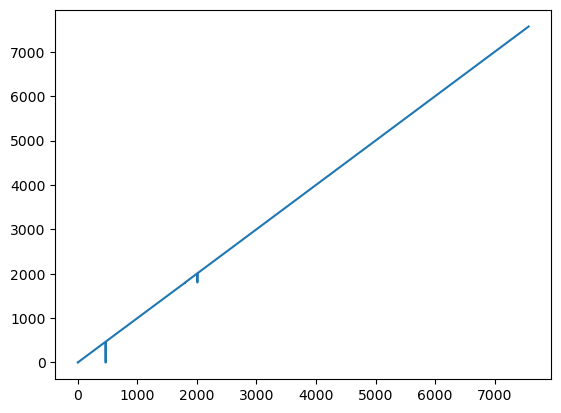

In [126]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(I)